In [15]:
# Keeping config up front so it's easy to tweak later.
import os, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from scipy.sparse import hstack, issparse
import joblib

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['axes.grid'] = True

# Preconfig for Kaggle DETE/TAFE Employee Exit Survey
CSV_PATH = 'employee_exit_survey.csv'      # put the CSV in this folder
TARGET_COL = 'primary_reason'              # I'll derive this
TEXT_COL   = 'comments'                    # free-text if available
NUMERIC_COLS = ['Age','Length_of_Service']
CATEGORICAL_COLS = ['Gender','Department']
CLASS_ORDER = ['Compensation','Career Growth','Relocation','Work-Life','Management','Other']
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [16]:
import sys
import sklearn
print("Python:", sys.version)
print("scikit-learn:", sklearn.__version__)
print("pandas:", pd.__version__)
print("numpy:", np.__version__)

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
scikit-learn: 1.6.1
pandas: 2.2.2
numpy: 2.0.2


In [18]:
# First look: standardize headers so downstream code is predictable.
df = pd.read_csv(CSV_PATH)
df.columns = [c.strip().replace(' ','_') for c in df.columns]
print("Rows:", len(df))
df.head(3)

Rows: 822


,ID,SeparationType,Cease_Date,DETE_Start_Date,Role_Start_Date,Position,Classification,Region,Business_Unit,Employment_Status,...,Kept_informed,Wellness_programs,Health_&_Safety,Gender,Age,Aboriginal,Torres_Strait,South_Sea,Disability,NESB
0,1,Ill Health Retirement,08/2012,1984,2004,Public Servant,A01-A04,Central Office,Corporate Strategy and Peformance,Permanent Full-time,...,N,N,N,Male,56-60,NaN,NaN,NaN,NaN,Yes
1,2,Voluntary Early Retirement (VER),08/2012,Not Stated,Not Stated,Public Servant,AO5-AO7,Central Office,Corporate Strategy and Peformance,Permanent Full-time,...,N,N,N,Male,56-60,NaN,NaN,NaN,NaN,NaN
2,3,Voluntary Early Retirement (VER),05/2012,2011,2011,Schools Officer,NaN,Central Office,Education Queensland,Permanent Full-time,...,N,N,N,Male,61 or older,NaN,NaN,NaN,NaN,NaN


In [19]:
# Map “what the dataset calls it” -> “what I’ll use below”.
def first_present(cols):
    for c in cols:
        if c in df.columns:
            return c
    return None

maps = {
    'Age': first_present(['Age','age','Age_Group','AgeBracket','Age_Range']),
    'Length_of_Service': first_present(['Length_of_Service','length_of_service','Tenure_Years','YearsAtCompany','Years_at_Company','tenure']),
    'Gender': first_present(['Gender','gender','Sex']),
    'Department': first_present(['Department','dept','Business_Unit','Division','Job_Division','Business_Area']),
    'comments': first_present(['Comments','comments','comment','separation_comment','Exit_Comments','ExitComment'])
}
for canon, found in maps.items():
    if found and found != canon:
        df.rename(columns={found: canon}, inplace=True)

# Age sometimes arrives as ranges; make it numeric so imputer/scaler behave.
def age_to_num(val):
    if pd.isna(val): return np.nan
    s = str(val).strip()
    if '-' in s:
        a,b = s.split('-')[0], s.split('-')[1].rstrip('+')
        try: return (float(a)+float(b))/2.0
        except: return np.nan
    if s.endswith('+'):
        try: return float(s.rstrip('+'))
        except: return np.nan
    if 'older' in s.lower():
        nums=[float(x) for x in s.split() if x.isdigit()]
        return nums[0] if nums else np.nan
    if 'under' in s.lower():
        nums=[float(x) for x in s.split() if x.isdigit()]
        return (nums[0]-2) if nums else np.nan
    try: return float(s)
    except: return np.nan

if 'Age' in df.columns and not pd.api.types.is_numeric_dtype(df['Age']):
    df['Age'] = df['Age'].apply(age_to_num)

# Construct the list of columns to display, ensuring 'Length_of_Service' is included only if found
cols_to_display = []
if maps['Length_of_Service']:
    cols_to_display.append('Length_of_Service')
cols_to_display.extend([c for c in ['Age', 'Gender', 'Department', 'comments'] if c in df.columns])

df[cols_to_display].head(3)

,Age,Gender,Department
0,58.0,Male,Corporate Strategy and Peformance
1,58.0,Male,Corporate Strategy and Peformance
2,61.0,Male,Education Queensland


In [20]:
# The dataset spreads “why they left” across columns; build a unified label with simple keyword rules.
explicit = [c for c in df.columns if c.lower() in ['primary_reason','reason_for_leaving']]

def derive_reason(row):
    parts=[]
    for k,v in row.items():
        kl=str(k).lower()
        if ('reason' in kl) or ('separat' in kl) or ('resign' in kl) or ('termination' in kl) or ('exit' in kl):
            parts.append(str(v))
    text=' '.join(parts).lower()
    if not text and 'comments' in row.index:
        text=str(row.get('comments','')).lower()
    if any(k in text for k in ['pay','salary','compens','bonus','underpaid','market rate']): return 'Compensation'
    if any(k in text for k in ['promotion','career','growth','advance','advancement','progression','development']): return 'Career Growth'
    if any(k in text for k in ['relocat','move','moved','migrat']): return 'Relocation'
    if any(k in text for k in ['work-life','work life','hours','schedule','flex','remote','hybrid','overtime','balance']): return 'Work-Life'
    if any(k in text for k in ['manager','management','supervisor','leadership','boss','toxic','culture','harass','bully']): return 'Management'
    if any(k in text for k in ['retire','retirement','health','medical','family','personal']): return 'Other'
    return 'Other'

if explicit:
    df[TARGET_COL] = df[explicit[0]].astype(str).str.strip()
else:
    looks_like_reason = [c for c in df.columns if any(tok in c.lower() for tok in ['reason','separat','resign','termination','exit'])]
    if looks_like_reason or ('comments' in df.columns):
        df[TARGET_COL] = df.apply(derive_reason, axis=1)
    else:
        df[TARGET_COL] = 'Other'

# Keep only known classes; map anything else to 'Other' for stability.
df[TARGET_COL] = df[TARGET_COL].where(df[TARGET_COL].isin(CLASS_ORDER), other='Other')
df = df[df[TARGET_COL].astype(str).str.strip()!=''].copy()

print("Target distribution:")
print(df[TARGET_COL].value_counts())

Target distribution:
primary_reason
Other         752
Relocation     70
Name: count, dtype: int64


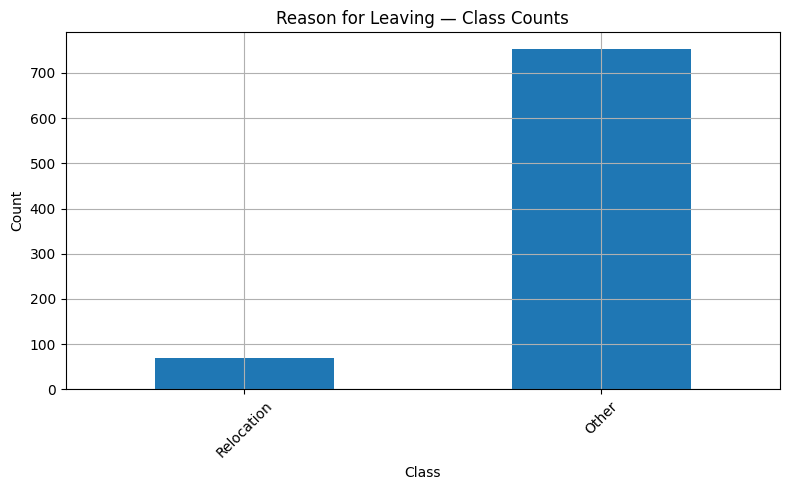

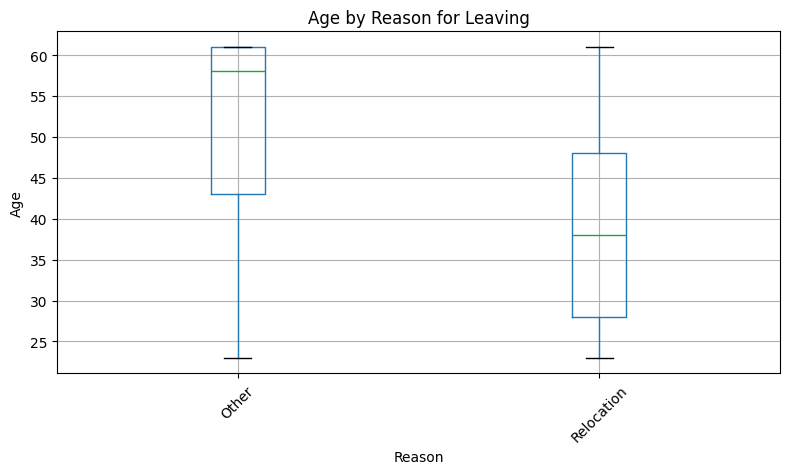

In [21]:
# Sanity-check class skew + basic relationships we care about.
os.makedirs('figures', exist_ok=True)

# 1) class distribution
df[TARGET_COL].value_counts().reindex(
    CLASS_ORDER + [c for c in df[TARGET_COL].unique() if c not in CLASS_ORDER]
).dropna().plot(kind='bar', rot=45)
plt.title('Reason for Leaving — Class Counts')
plt.xlabel('Class'); plt.ylabel('Count'); plt.tight_layout()
plt.savefig('figures/class_counts.png'); plt.show()

# 2) tenure vs reason
if 'Length_of_Service' in df.columns and pd.api.types.is_numeric_dtype(df['Length_of_Service']):
    df.boxplot(column='Length_of_Service', by=TARGET_COL, rot=45)
    plt.title('Length of Service by Reason for Leaving'); plt.suptitle('')
    plt.xlabel('Reason'); plt.ylabel('Years'); plt.tight_layout()
    plt.savefig('figures/tenure_by_reason.png'); plt.show()

# 3) age vs reason
if 'Age' in df.columns and pd.api.types.is_numeric_dtype(df['Age']):
    df.boxplot(column='Age', by=TARGET_COL, rot=45)
    plt.title('Age by Reason for Leaving'); plt.suptitle('')
    plt.xlabel('Reason'); plt.ylabel('Age'); plt.tight_layout()
    plt.savefig('figures/age_by_reason.png'); plt.show()

In [22]:
# Numeric → median impute + standardize; Categorical → most_frequent + one-hot; Text → TF-IDF(1–2 grams).
FEATURE_NUMS = [c for c in NUMERIC_COLS if c in df.columns and pd.api.types.is_numeric_dtype(df[c])]
FEATURE_CATS = [c for c in CATEGORICAL_COLS if c in df.columns]
FEATURE_TEXT = TEXT_COL if (TEXT_COL and TEXT_COL in df.columns) else None

X_cols = FEATURE_NUMS + FEATURE_CATS + ([FEATURE_TEXT] if FEATURE_TEXT else [])
X = df[X_cols].copy()
y = df[TARGET_COL].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y if y.nunique()>1 else None
)

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=False))
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, FEATURE_NUMS if FEATURE_NUMS else []),
        ('cat', categorical_transformer, FEATURE_CATS if FEATURE_CATS else [])
    ],
    remainder='drop'
)

Xs_train = preprocess.fit_transform(X_train)
Xs_test  = preprocess.transform(X_test)
Xs_train.shape, Xs_test.shape

((575, 15), (247, 15))

In [23]:
# Stack TF-IDF on the right of structured features so algorithms see one matrix.
if FEATURE_TEXT:
    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3)
    Xt_train = tfidf.fit_transform(X_train[FEATURE_TEXT].astype(str).fillna(''))
    Xt_test  = tfidf.transform(X_test[FEATURE_TEXT].astype(str).fillna(''))
    X_train_mat = hstack([Xs_train, Xt_train]).tocsr()
    X_test_mat  = hstack([Xs_test,  Xt_test]).tocsr()
else:
    tfidf = None
    X_train_mat, X_test_mat = Xs_train, Xs_test

print("Train/Test matrices:", X_train_mat.shape, X_test_mat.shape)

Train/Test matrices: (575, 15) (247, 15)


,Model,CV_Mean_Acc,CV_Std
0,LogisticRegression,0.914783,0.003478
5,KNN,0.914783,0.003478
1,NaiveBayes,0.913043,0.005500
4,LinearSVM,0.913043,0.005500
3,RandomForest,0.906087,0.010141
2,DecisionTree,0.897391,0.011536


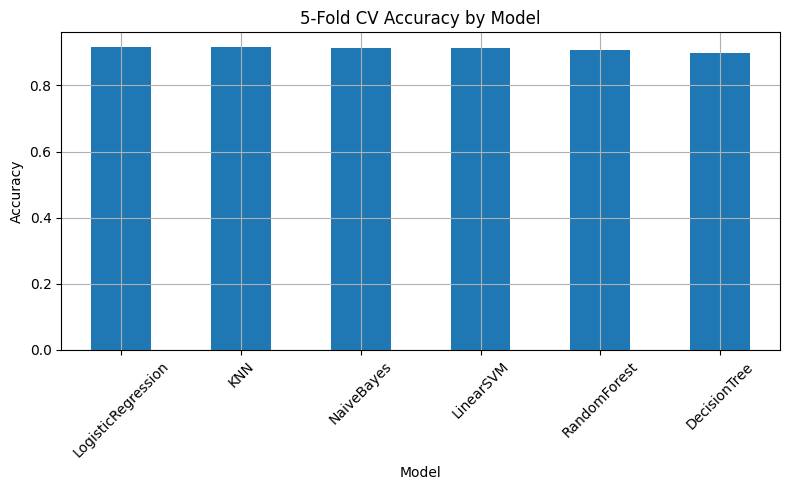

In [24]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=200, random_state=RANDOM_STATE),
    'NaiveBayes': MultinomialNB(),
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE),
    'LinearSVM': LinearSVC(random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(n_neighbors=7),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE) if y_train.nunique()>1 else None

cv_rows=[]
if cv:
    for name, mdl in models.items():
        X_cv = X_train_mat
        if name=='NaiveBayes':
            Xmin = X_cv.min()
            if Xmin < 0: X_cv = X_cv - Xmin
        scores = cross_val_score(mdl, X_cv, y_train, cv=cv, scoring='accuracy')
        cv_rows.append({'Model':name, 'CV_Mean_Acc':scores.mean(), 'CV_Std':scores.std()})
else:
    for name in models.keys():
        cv_rows.append({'Model':name, 'CV_Mean_Acc':np.nan, 'CV_Std':np.nan})

cv_df = pd.DataFrame(cv_rows).sort_values('CV_Mean_Acc', ascending=False)
display(cv_df)

# Save CV plot
if not cv_df['CV_Mean_Acc'].isna().all():
    ax = cv_df.set_index('Model')['CV_Mean_Acc'].plot(kind='bar', rot=45)
    ax.set_title('5-Fold CV Accuracy by Model'); ax.set_ylabel('Accuracy'); plt.tight_layout()
    os.makedirs('figures', exist_ok=True)
    plt.savefig('figures/cv_accuracy.png'); plt.show()

,Model,Accuracy,Precision_w,Recall_w,F1_w
0,LogisticRegression,0.914980,0.837188,0.914980,0.874357
1,NaiveBayes,0.914980,0.837188,0.914980,0.874357
5,KNN,0.914980,0.837188,0.914980,0.874357
4,LinearSVM,0.914980,0.837188,0.914980,0.874357
3,RandomForest,0.890688,0.849040,0.890688,0.867715
2,DecisionTree,0.886640,0.834919,0.886640,0.860002


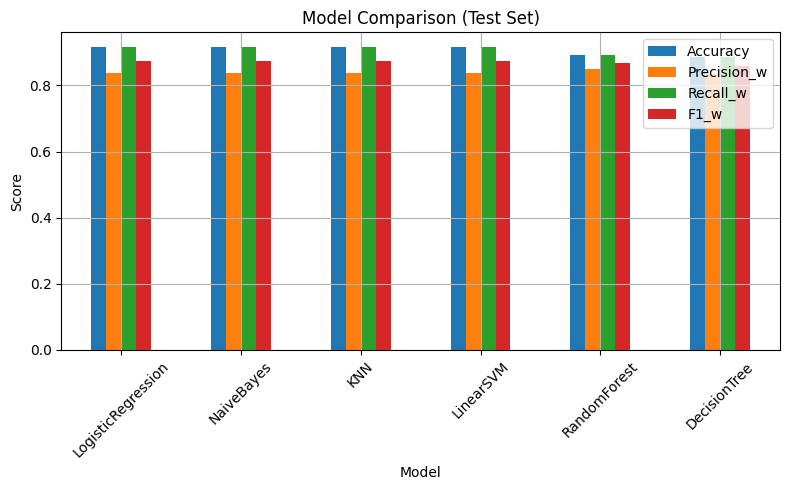

LogisticRegression
              precision    recall  f1-score   support

       Other       0.91      1.00      0.96       226
  Relocation       0.00      0.00      0.00        21

    accuracy                           0.91       247
   macro avg       0.46      0.50      0.48       247
weighted avg       0.84      0.91      0.87       247

NaiveBayes
              precision    recall  f1-score   support

       Other       0.91      1.00      0.96       226
  Relocation       0.00      0.00      0.00        21

    accuracy                           0.91       247
   macro avg       0.46      0.50      0.48       247
weighted avg       0.84      0.91      0.87       247

DecisionTree
              precision    recall  f1-score   support

       Other       0.91      0.97      0.94       226
  Relocation       0.00      0.00      0.00        21

    accuracy                           0.89       247
   macro avg       0.46      0.48      0.47       247
weighted avg       0.83      0.

In [25]:
test_rows=[]; reports={}
best_name=None; best_acc=-1.0; best_model=None

for name, mdl in models.items():
    X_fit, X_eval = X_train_mat, X_test_mat
    if name=='NaiveBayes':
        Xmin = X_fit.min()
        if Xmin < 0:
            X_fit = X_fit - Xmin
            X_eval = X_eval - Xmin
    mdl.fit(X_fit, y_train)
    preds = mdl.predict(X_eval)
    acc = accuracy_score(y_test, preds)
    pr, rc, f1, _ = precision_recall_fscore_support(y_test, preds, average='weighted', zero_division=0)
    test_rows.append({'Model':name, 'Accuracy':acc, 'Precision_w':pr, 'Recall_w':rc, 'F1_w':f1})
    reports[name] = classification_report(y_test, preds, zero_division=0)
    if acc > best_acc:
        best_acc = acc; best_name = name; best_model = mdl

test_df = pd.DataFrame(test_rows).sort_values('Accuracy', ascending=False)
display(test_df)

ax = test_df.set_index('Model')[['Accuracy','Precision_w','Recall_w','F1_w']].plot(kind='bar', rot=45)
ax.set_title('Model Comparison (Test Set)'); ax.set_ylabel('Score'); plt.tight_layout()
plt.savefig('figures/test_metrics.png'); plt.show()

# Brief per-model reports (useful if I need class-level detail later).
for k,v in reports.items():
    print('='*80); print(k); print(v)

print(f'\nSelected best model for deployment: {best_name}  (Accuracy={best_acc:.3f})')

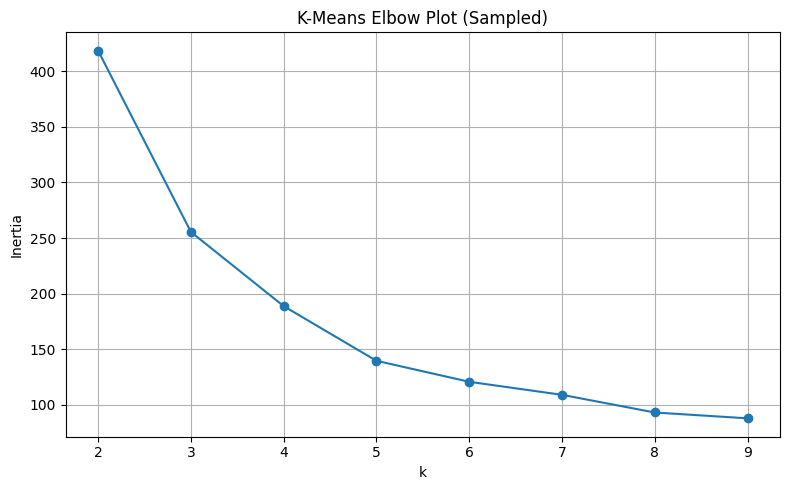

In [26]:
# This is for the assignment requirement; I’m not using clusters for deployment.
max_rows = 2000
if X_train_mat.shape[0] > max_rows:
    idx = np.random.choice(X_train_mat.shape[0], size=max_rows, replace=False)
    Xs_for_kmeans = X_train_mat[idx] if issparse(X_train_mat) else X_train_mat[idx, :]
else:
    Xs_for_kmeans = X_train_mat

inertias=[]
for k in range(2,10):
    km = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    km.fit(Xs_for_kmeans)
    inertias.append(km.inertia_)

plt.plot(list(range(2,10)), inertias, marker='o')
plt.title('K-Means Elbow Plot (Sampled)'); plt.xlabel('k'); plt.ylabel('Inertia'); plt.tight_layout()
plt.savefig('figures/kmeans_elbow.png'); plt.show()

In [27]:
# Refit preprocessors on FULL data and save the chosen model (+ config) for deployment.
os.makedirs('artifacts', exist_ok=True)

full_pre = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), FEATURE_NUMS if FEATURE_NUMS else []),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                          ('onehot', OneHotEncoder(handle_unknown='ignore'))]),
         FEATURE_CATS if FEATURE_CATS else []),
    ],
    remainder='drop'
)
full_pre = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('imputer', SimpleImputer(strategy='median')),
                          ('scaler', StandardScaler(with_mean=False))]), FEATURE_NUMS if FEATURE_NUMS else []),
        ('cat', Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                          ('onehot', OneHotEncoder(handle_unknown='ignore'))]), FEATURE_CATS if FEATURE_CATS else []),
    ],
    remainder='drop'
).fit(df[X_cols])

full_tfidf = None
if FEATURE_TEXT:
    full_tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=3).fit(df[FEATURE_TEXT].astype(str).fillna(''))

Xs_full = full_pre.transform(df[X_cols])
if FEATURE_TEXT:
    Xt_full = full_tfidf.transform(df[FEATURE_TEXT].astype(str).fillna(''))
    X_full = hstack([Xs_full, Xt_full]).tocsr()
else:
    X_full = Xs_full

best_model.fit(X_full, df[TARGET_COL])

joblib.dump(best_model, 'best_model.pkl')
joblib.dump(full_pre,   'preprocess.pkl')
joblib.dump(full_tfidf, 'text_vectorizer.pkl')

# Build dropdown choices from training data
cat_choices = {}
for col in (FEATURE_CATS or []):
    vals = (
        df[col]
        .dropna()
        .astype(str)
        .unique()
        .tolist()
    )
    vals = sorted(vals)
    # Optional: cap very large sets
    MAX_CHOICES = 50
    if len(vals) > MAX_CHOICES:
        # keep most frequent
        top = (
            df[col].astype(str)
            .value_counts()
            .head(MAX_CHOICES)
            .index.tolist()
        )
        vals = sorted(top)
    # Optional: add a generic fallback
    if "Other" not in vals:
        vals.append("Other")
    cat_choices[col] = vals

joblib.dump(
    {
        'NUMERIC_COLS': FEATURE_NUMS,
        'CATEGORICAL_COLS': FEATURE_CATS,
        'TEXT_COL': FEATURE_TEXT,
        'TARGET_COL': TARGET_COL,
        'CLASS_ORDER': CLASS_ORDER,
        'CATEGORICAL_CHOICES': cat_choices,   # <-- added
    },
    'column_config.pkl'
)

print("Artifacts saved for Streamlit: artifacts/best_model.pkl, preprocess.pkl, text_vectorizer.pkl, column_config.pkl")

Artifacts saved for Streamlit: artifacts/best_model.pkl, preprocess.pkl, text_vectorizer.pkl, column_config.pkl


In [28]:
# This prints a concise narrative using actual results. Handy for the 1‑pager or README.
best_row = test_df.iloc[0]
summary_lines = [
    "Project notes while coding:",
    f"- After normalizing headers and converting Age to numeric (range midpoints), target distribution was:\n{df[TARGET_COL].value_counts().to_string()}",
    f"- Features in final run: Numeric={FEATURE_NUMS or []}, Categorical={FEATURE_CATS or []}, Text={'comments' if FEATURE_TEXT else 'None'}.",
    f"- 5-fold CV results saved to figures/cv_accuracy.png; test comparison saved to figures/test_metrics.png.",
    f"- Best model selected: {best_row['Model']}  |  Test Accuracy={best_row['Accuracy']:.3f}  |  Weighted F1={best_row['F1_w']:.3f}.",
    "- K-Means elbow (diagnostic): figures/kmeans_elbow.png.",
    "- Artifacts saved for Streamlit: artifacts/best_model.pkl, preprocess.pkl, text_vectorizer.pkl, column_config.pkl."
]
print("\n" + "\n".join(summary_lines))


Project notes while coding:
- After normalizing headers and converting Age to numeric (range midpoints), target distribution was:
primary_reason
Other         752
Relocation     70
- Features in final run: Numeric=['Age'], Categorical=['Gender', 'Department'], Text=None.
- 5-fold CV results saved to figures/cv_accuracy.png; test comparison saved to figures/test_metrics.png.
- Best model selected: LogisticRegression  |  Test Accuracy=0.915  |  Weighted F1=0.874.
- K-Means elbow (diagnostic): figures/kmeans_elbow.png.
- Artifacts saved for Streamlit: artifacts/best_model.pkl, preprocess.pkl, text_vectorizer.pkl, column_config.pkl.
